In [45]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import leastsq
from scipy.stats import norm

In [50]:
def vec_to_poly(feat):
    powers = np.arange(len(feat))
    powerf = lambda x: np.dot(feat, x**powers)
    return np.vectorize(powerf)

def likelihood(a, x_obs, y_obs):
    rho = norm(scale=SIGMA).pdf
    return rho(vec_to_poly(a)(x_obs) - y_obs)

In [14]:
def leastsq_fit(x_obs, y_obs, degree):
    a_0 = np.zeros(degree)
    a, flag = leastsq(lambda a: y_obs - vec_to_poly(a)(x_obs), a_0)
    if flag not in {1, 2, 3, 4}:
        raise RuntimeError("Solver did not converge")
    return a

In [32]:
def prederr(x_obs, y_obs, a):
    f = vec_to_poly(a)
    return np.sum((y_obs - f(x_obs))**2) / len(x_obs)**2

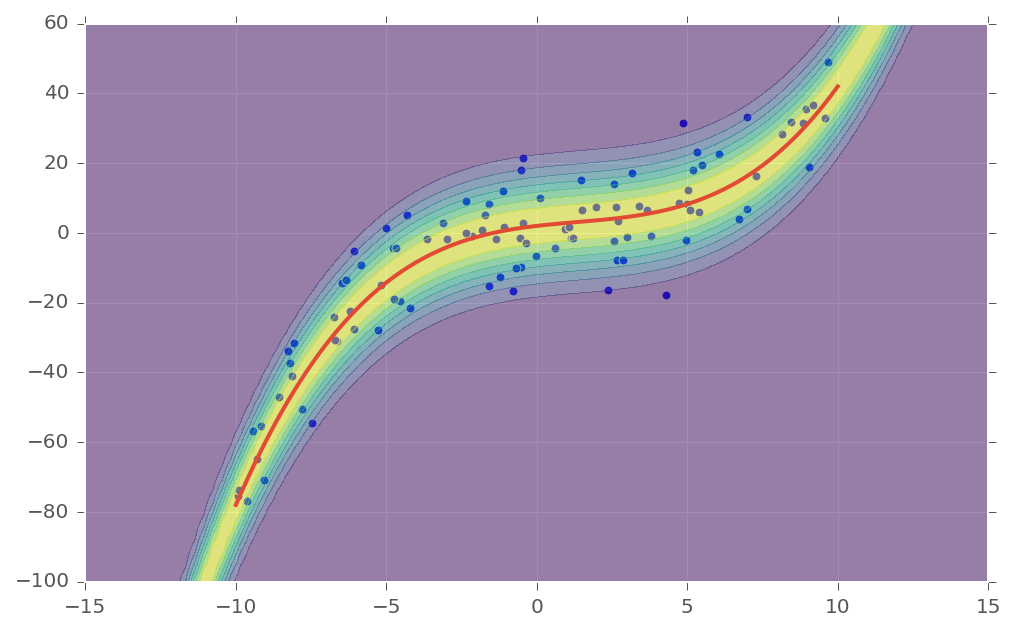

In [72]:
OBS_RANGE = (-10, 10)
SAMPLES = 100
SIGMA = 10.0
A_TRUE = np.array([2, 1, -.2, .05])

x_obs = np.random.uniform(*OBS_RANGE, SAMPLES)
y_obs = vec_to_poly(A_TRUE)(x_obs) + SIGMA * np.random.randn(*x_obs.shape)

x = np.linspace(*OBS_RANGE, 1000)
ax = pl.gca()
ax.plot(x, vec_to_poly(A_TRUE)(x))
ax.scatter(x_obs, y_obs)

axis = ax.axis()
xx, yy = np.meshgrid(np.linspace(*ax.get_xlim(), 100),
                     np.linspace(*ax.get_ylim(), 100))
l = likelihood(A_TRUE, xx, yy)
pl.contourf(xx, yy, l, alpha=.5)
ax.axis(axis)
pl.show()

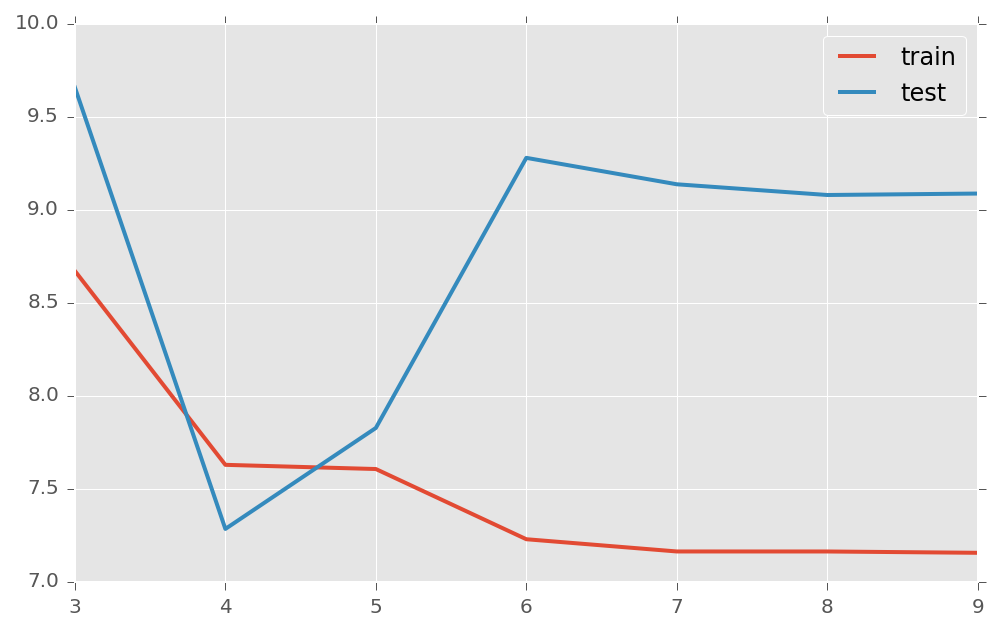

In [74]:
x_train, x_test = x_obs[SAMPLES // 2:], x_obs[:SAMPLES // 2]
y_train, y_test = y_obs[SAMPLES // 2:], y_obs[:SAMPLES // 2]
degrees = range(3, 10)

fits = [leastsq_fit(x_train, y_train, degree) for degree in degrees]
errs_cv = np.array([(prederr(x_train, y_train, a), prederr(x_test, y_test, a))
                   for a in fits],
                  dtype=[('train', float), ('test', float)])
pl.plot(degrees, errs['train'], label='train')
pl.plot(degrees, errs['test'], label='test')
pl.legend()

In [67]:
def aic(x, y, a):
    L = likelihood(a, x, y)
    return 2 * (len(a) - sum(np.log(L)))

def aicc(x, y, a):
    n = len(x)
    k = len(a)
    return aic(x, y, a) + 2*k*(k+1) / (n - k - 1)

def bic(x, y, a):
    return len(a) * np.log(len(x)) - 2 * sum(np.log(likelihood(a, x, y)))

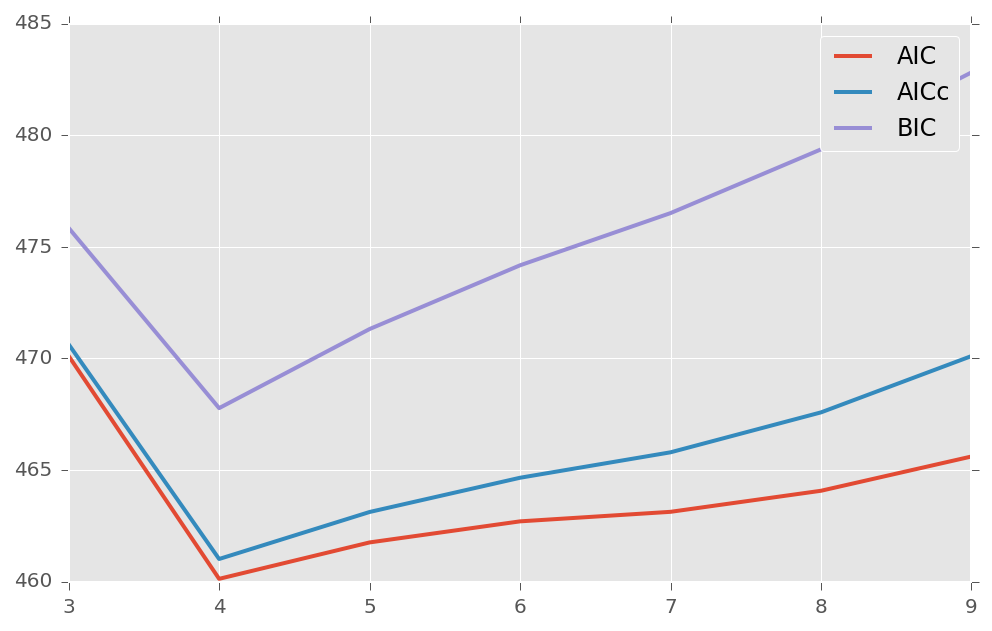

In [68]:
errs_aic = np.array([aic(x_train, y_train, a) for a in fits])
errs_aicc = np.array([aicc(x_train, y_train, a) for a in fits])
errs_bic = np.array([bic(x_train, y_train, a) for a in fits])

pl.plot(degrees, errs_aic, label="AIC")
pl.plot(degrees, errs_aicc, label="AICc")
pl.plot(degrees, errs_bic, label="BIC")
pl.legend()